In [2]:
pwd

'/home/students/anigovin/final_project'

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

NameError: name 'tf' is not defined

# Data 

In [3]:
import os
import glob

base_dir = os.path.join('./cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13779)

# Labelling 

In [4]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,./cell_images/Parasitized/C180P141NThinF_IMG_2...,malaria
1,./cell_images/Parasitized/C181P142ThinF_IMG_20...,malaria
2,./cell_images/Uninfected/C204ThinF_IMG_2015102...,healthy
3,./cell_images/Uninfected/C76P37ThinF_IMG_20150...,healthy
4,./cell_images/Uninfected/C141P102ThinF_IMG_201...,healthy


# Spliting data (60,10,30)

In [5]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17361,) (1929,) (8268,)
Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


# Dimension of the images (test not included)

In [6]:
import cv2
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))


Starting Img shape computation:
Thread-4: working on img num: 0
Thread-66: working on img num: 5000
Thread-24: working on img num: 10000
Thread-29: working on img num: 15000
Thread-18: working on img num: 17360
Min Dimensions: [46 46  3]
Avg Dimensions: [132.93329877 132.28909625   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [385 364   3]


# Reshape

In [7]:
IMG_DIMS = (100, 100)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:
Thread-84: working on img num: 0
Thread-125: working on img num: 5000
Thread-120: working on img num: 10000
Thread-160: working on img num: 15000
Thread-147: working on img num: 17360

Loading Validation Images:
Thread-104: working on img num: 0
Thread-137: working on img num: 1928

Loading Test Images:
Thread-122: working on img num: 0
Thread-160: working on img num: 5000
Thread-155: working on img num: 8267


((17361, 100, 100, 3), (1929, 100, 100, 3), (8268, 100, 100, 3))

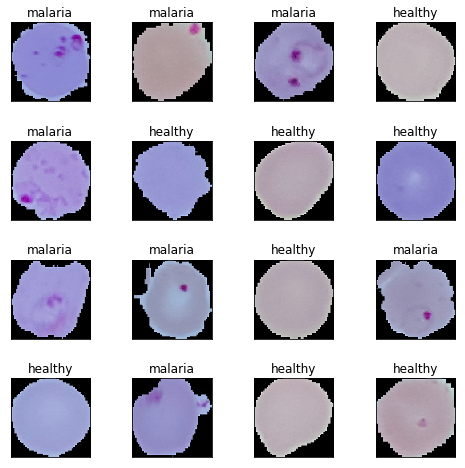

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [9]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 10
INPUT_SHAPE = (100, 100, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['malaria' 'malaria' 'malaria' 'healthy' 'healthy' 'malaria'] [1 1 1 0 0 1]


In [10]:
import tensorflow as tf

tf.random.set_random_seed(42)

# Model construction  

In [11]:
# inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

# conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
#                                activation='relu', padding='same')(inp)
# pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
# conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
#                                activation='relu', padding='same')(pool1)
# pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
# conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
#                                activation='relu', padding='same')(pool2)
# pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

# flat = tf.keras.layers.Flatten()(pool3)

# hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
# drop1 = tf.keras.layers.Dropout(rate=0.7)(hidden1)
# hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
# drop2 = tf.keras.layers.Dropout(rate=0.7)(hidden2)

# out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

# model = tf.keras.Model(inputs=inp, outputs=out)
# model.compile(optimizer='adam',
#                 loss='binary_crossentropy',
#                 metrics=['accuracy'])
# model.summary()


In [14]:
def MalariaModel():
    model = Sequential()
    model.add(Conv2D(filters = 12, kernel_size = 3, activation = 'relu', padding = 'same', name = 'a11', input_shape = (100, 100, 3)))  
    model.add(MaxPooling2D(pool_size = 2, strides = 1, name = 'a12'))
    #model.add(BatchNormalization(name = 'a13'))
    #input = (128,128,4)
    model.add(Conv2D(filters = 12, kernel_size = 3, activation = 'relu', padding = 'same', name = 'a21'))   
    model.add(MaxPooling2D(pool_size = 2, strides = 2, name = 'a22'))
    #model.add(BatchNormalization(name = 'a23'))
    #input = (64,64,8)
    #model.add(Conv2D(filters = 12, kernel_size = 3, activation = 'relu', padding = 'same', name = 'a31'))   
    #model.add(AveragePooling2D(pool_size = 2, strides = 2, name = 'a32'))
    
    #model.add(BatchNormalization(name = 'a33'))
    #input = (32,32,16)
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation = 'relu', name = 'fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(200, activation = 'relu', name = 'fc2'))
    model.add(Dense(1, activation = 'sigmoid', name = 'prediction'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D,Dropout,BatchNormalization,Flatten,AveragePooling2D

modelone = MalariaModel()
modelone.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a11 (Conv2D)                 (None, 100, 100, 12)      336       
_________________________________________________________________
a12 (MaxPooling2D)           (None, 99, 99, 12)        0         
_________________________________________________________________
a21 (Conv2D)                 (None, 99, 99, 12)        1308      
_________________________________________________________________
a22 (MaxPooling2D)           (None, 49, 49, 12)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 28812)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 28812)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 100)               2881300   
__________

In [ ]:
output = modelone.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 17361 samples, validate on 1929 samples
Epoch 1/10


In [1]:
preds = modelone.evaluate(x = test_imgs_scaled,y = test_labels_enc)
print("Test Accuracy : %.2f%%" % (preds[1]*100))


NameError: name 'modelone' is not defined

In [ ]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    verbose=1)

Train on 17361 samples, validate on 1929 samples
Instructions for updating:
Use tf.cast instead.
